In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('merged_data.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df.head()

,Game_date,Games_played_to_date,BA,PA,Name,ISO,SLG,BABIP,BIP,OBP,...,strike_percentage,pitches_per_appearance_avg,ground_ball_percentage,fly_ball_percentage,strikeout_percentage,next_game_team1,next_game_team2,hitter_R%,hitter_L%,next_game_hit_vs_fp
0,2014-03-31,1,0.00000,4,Travis d'Arnaud,0.0,0.00000,0.00000,0.33333,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0
1,2014-03-31,1,0.20000,5,Jayson Werth,0.0,0.20000,0.33333,0.60000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
2,2014-03-31,1,0.25000,5,Ian Desmond,0.0,0.25000,0.25000,1.00000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
3,2014-03-31,1,0.25000,5,Bryce Harper,0.0,0.25000,0.50000,0.50000,0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0
4,2014-03-31,1,0.33333,5,Adam LaRoche,1.0,1.33333,0.00000,1.00000,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1


In [3]:
train = df._get_numeric_data()
train.shape[1]

227

In [4]:
for i in df.columns:
    if str(type(df.at[df[i].first_valid_index(), i])) == "<class 'numpy.int64'>" or str(type(df.at[df[i].first_valid_index(), i])) == "<class 'numpy.float64'>" or isinstance(df.at[df[i].first_valid_index(), i], int) or isinstance(df.at[df[i].first_valid_index(), i], float):
        print (i)

Games_played_to_date
BA
PA
ISO
SLG
BABIP
BIP
OBP
OPS
LA_avg
LA_median
Walks
next_game_HIT
H_total_next_game
AB_next_game
Walks_next_game
AB_vs_first_pitcher
earliest_inning
first_pitcher_faced_next_game_id
hits_vs_first_pitcher
BA_last_10_games
BA_last_20_games
BA_last_30_games
BABIP_last_10_games
BABIP_last_20_games
BABIP_last_30_games
BIP_last_10_games
BIP_last_20_games
BIP_last_30_games
ISO_last_10_games
ISO_last_20_games
ISO_last_30_games
LAmed_last_10_games
LAmed_last_20_games
LAmed_last_30_games
OBP_last_10_games
OBP_last_20_games
OBP_last_30_games
OPS_last_10_games
OPS_last_20_games
OPS_last_30_games
PA_last_10_games
PA_last_20_games
PA_last_30_games
SLG_last_10_games
SLG_last_20_games
SLG_last_30_games
Walks_last_10_games
Walks_last_20_games
Walks_last_30_games
mlbam_code
Flare/Burner_lsa_p
SolidContact_lsa_p
Topped_lsa_p
Under_lsa_p
Barrel_lsa_p
Weak_lsa_p
CH_percentage_hits
CU_percentage_hits
EP_percentage_hits
FA_percentage_hits
FC_percentage_hits
FF_percentage_hits
FO_perce

In [5]:
for i in df.columns:
    if not (str(type(df.at[df[i].first_valid_index(), i])) == "<class 'numpy.int64'>" or str(type(df.at[df[i].first_valid_index(), i])) == "<class 'numpy.float64'>" or isinstance(df.at[df[i].first_valid_index(), i], int) or isinstance(df.at[df[i].first_valid_index(), i], float)):
        print (i)

Game_date
Name
next_game_date
HomeTeam
AwayTeam
Date_x
Team 1
Team 2
Venue
Weather Type
Wind Direction
Year_x
PARK NAME
PARKID
LEAGUE
CITY
Foul
Pitcher_Name
Pitcher_ID
Date_y
Team
At
Opponent
Result
Innings
Decision
Entered
Exited
name_last
name_first
key_retro
key_bbref
next_game_team1
next_game_team2


In [6]:
train = train.drop(['next_game_HIT'], axis = 1)
train = train.drop(['H_total_next_game'], axis = 1)
train = train.drop(['AB_next_game'], axis = 1)
train = train.drop(['Walks_next_game'], axis = 1)
train = train.drop(['next_game_hit_vs_fp'], axis = 1)
train = train.drop(['hits_vs_first_pitcher'], axis = 1)
train = train.drop(['Team 1 Score'], axis = 1)
train = train.drop(['Team 2 Score'], axis = 1)
train = train.drop(['Game_Score'], axis = 1)
train = train.drop(['Inherited_Score'], axis = 1)
train = train.drop(['key_fangraphs'], axis = 1)
train = train.drop(['first_pitcher_faced_next_game_id'], axis = 1)
train = train.drop(['YEAR'], axis = 1)
train = train.drop(['nYear'], axis = 1)
train = train.drop(['Year_y'], axis = 1)
train = train.drop(['key_mlbam'], axis = 1)
train = train.drop(['mlb_played_first'], axis = 1)
train = train.drop(['mlb_played_last'], axis = 1)
train = train.drop(['Game_Number'], axis = 1)
train = train.drop(['Team_Game_Number'], axis = 1)
test = df['next_game_HIT']
train.head()

,Games_played_to_date,BA,PA,ISO,SLG,BABIP,BIP,OBP,OPS,LA_avg,...,wip_season,whip_season,batters_faced_on_season,strike_percentage,pitches_per_appearance_avg,ground_ball_percentage,fly_ball_percentage,strikeout_percentage,hitter_R%,hitter_L%
0,1,0.00000,4,0.0,0.00000,0.00000,0.33333,0.25,0.25000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,1,0.20000,5,0.0,0.20000,0.33333,0.60000,0.20,0.40000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2,1,0.25000,5,0.0,0.25000,0.25000,1.00000,0.20,0.45000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
3,1,0.25000,5,0.0,0.25000,0.50000,0.50000,0.40,0.65000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
4,1,0.33333,5,1.0,1.33333,0.00000,1.00000,0.60,1.93333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0


In [7]:
train = train.join(pd.get_dummies(df['Weather Type'], prefix = 'Weather'))
train = train.join(pd.get_dummies(df['Wind Direction'], prefix = 'Wind'))
train = train.join(pd.get_dummies(df['PARKID'], prefix = 'Park'))

In [8]:
for i in train.columns:    
    if (train.shape[0] - train[i].count()) / train.shape[0] > .3:
        print (i)
        train = train.drop([i], axis = 1)

BA_last_30_games
BABIP_last_30_games
BIP_last_30_games
ISO_last_30_games
LAmed_last_20_games
LAmed_last_30_games
OBP_last_30_games
OPS_last_30_games
PA_last_30_games
SLG_last_30_games
Walks_last_30_games
EP_percentage_hits
FA_percentage_hits
FO_percentage_hits
FS_percentage_hits
KC_percentage_hits
KN_percentage_hits
SC_percentage_hits
pHitsByZone11
pHitsByZone12
pHitsByZone3
Inherited_Runners
hip_last_ten
wip_last_ten


In [9]:
for i in train.columns:
    if len(train[i].unique()) > 2:
        train[i] = train[i].fillna(train[i].median())
    else:
        train[i] = train[i].fillna(train[i].mode()[0])

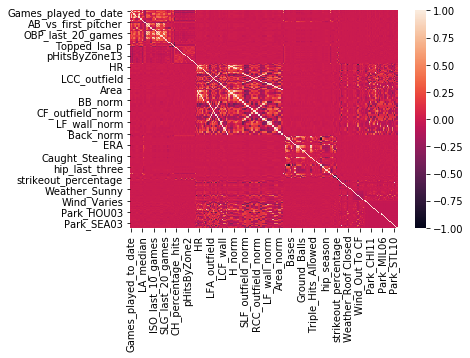

In [10]:
corr = train.corr()
sns.heatmap(corr)

In [11]:
#VIF better for collinearity
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train.columns[columns]
train = train[selected_columns]

In [12]:
def get_accuracy(predictions):
    acc = []
    predictions = [float(i) for i in predictions]
    comparison = pd.DataFrame({"Real" : y_test.iloc[:,0], "Predictions" : predictions})
    comparison = comparison.reset_index()
    comparison = comparison.drop(['index'], axis=1)
    correct = 0
    for i in range(len(comparison)):
        if comparison.at[i, 'Real'] == comparison.at[i, 'Predictions']:
            correct += 1
    acc.append(correct / len(comparison))
    false = comparison[comparison['Real'] != comparison['Predictions']]
    false = false.reset_index()
    false = false.drop(['index'], axis = 1)
    falsePositive = 0
    if len(false) == 0:
        acc.append(falsePositive)
    else:
        for i in range(len(false)):
            if false.at[i, 'Real'] == 0:
                falsePositive += 1
        acc.append(falsePositive / len(false))
    return acc

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

columns = train.columns
train = preprocessing.normalize(train)
train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test)

X, y = train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())
predictions = logreg.predict(X_test)
acc = get_accuracy(predictions)
print ('Accuracy: ' + str(acc[0]) + ' False Positive: ' + str(acc[1]))

Accuracy: 0.6379042288557214 False Positive: 1.0


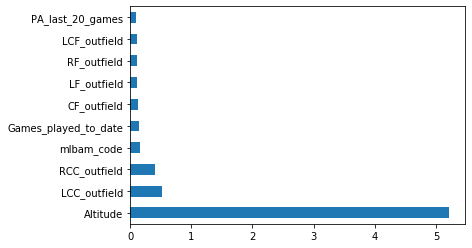

In [15]:
feat_importances = pd.Series(logreg.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

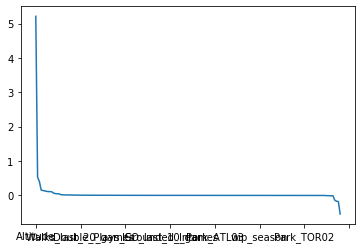

In [16]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line')

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
acc = get_accuracy(predictions)
print ('Accuracy: ' + str(acc[0]) + ' False Positive: ' + str(acc[1]))

Accuracy: 0.6342506218905473 False Positive: 0.9024442082890543


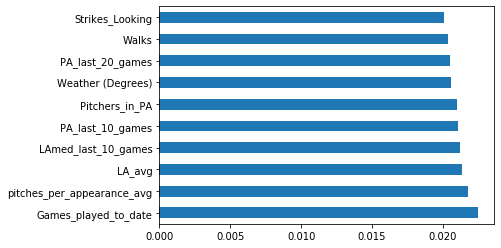

In [18]:
feat_importances = pd.Series(clf.feature_importances_, index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

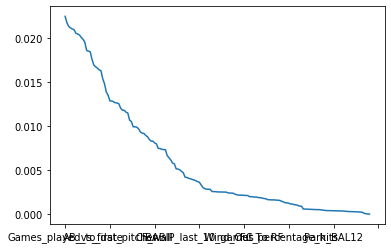

In [19]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line')

In [20]:
#rbf svc too slow to train
from sklearn.svm import LinearSVC

linsvc=LinearSVC()
linsvc.fit(X_train, y_train.values.ravel())
predictions = linsvc.predict(X_test)
acc = get_accuracy(predictions)
print ('Accuracy: ' + str(acc[0]) + ' False Positive: ' + str(acc[1]))

Accuracy: 0.6379042288557214 False Positive: 1.0


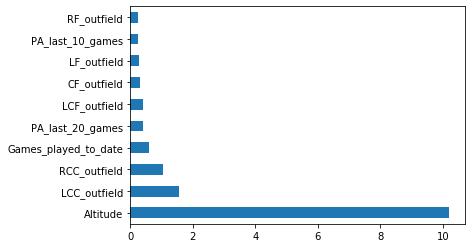

In [21]:
feat_importances = pd.Series(linsvc.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

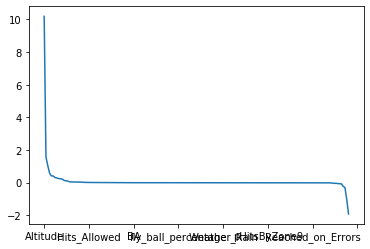

In [22]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line')

In [23]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

percentiles = [1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100]

for i in percentiles:
    
    fs = SelectPercentile(score_func=f_classif, percentile=i)
    fs.fit_transform(X_train, y_train.values.ravel())
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    logreg = LogisticRegression()
    logreg.fit(X_train_fs, y_train.values.ravel())
    predictions = logreg.predict(X_test_fs)
    acc = get_accuracy(predictions)
    print ('Percentile: ' + str(i) + ', Accuracy: ' + str(acc[0]) + ', False Positive: ' + str(acc[1]) + ', X_train: ' + str(X_train_fs.shape[0]) + ', ' + str(X_train_fs.shape[1]) + ', X_test: ' + str(X_test_fs.shape[0]) + ', ' + str(X_test_fs.shape[1]))

Percentile: 1, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 2, X_test: 38592, 2
Percentile: 3, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 6, X_test: 38592, 6
Percentile: 6, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 11, X_test: 38592, 11
Percentile: 10, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 17, X_test: 38592, 17
Percentile: 15, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 26, X_test: 38592, 26
Percentile: 20, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 34, X_test: 38592, 34
Percentile: 30, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 52, X_test: 38592, 52
Percentile: 40, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 68, X_test: 38592, 68
Percentile: 60, Accuracy: 0.6379042288557214, False Positive: 1.0, X_train: 154364, 102, X_test: 38592, 102
Percentile: 80, Accuracy: 0.6379042288557214, False

In [24]:
train = train.join(df['Name'])
train = train.join(df['next_game_HIT'])
names = train['Name'].unique().tolist()
temp = train['Name'].value_counts().to_frame()
temp = temp.reset_index()
temp.columns = ['Name', 'Count']
for i in range(len(temp)):
    if temp.at[i, 'Count'] < 30:
        names.remove(temp.at[i, 'Name'])

In [25]:
len(df['Name'].unique()) - len(names)

300

In [29]:
len(names) / len(df['Name'].unique()) 

0.7169811320754716

In [26]:
players = pd.DataFrame()

count = 0

for name in names:
    
    players.at[count, 'Name'] = name
    
    train2 = train[train['Name'] == name]
    train2 = train2.drop(['Name'], axis = 1)
    test2 = train2['next_game_HIT']
    train2 = train2.drop(['next_game_HIT'], axis = 1)
    
    players.at[count, 'Samples'] = train2.shape[0]
    
    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing

    columns = train2.columns
    train2 = preprocessing.normalize(train2)
    train2 = pd.DataFrame(train2, columns = columns)
    test2 = pd.DataFrame(test2)

    X, y = train2, test2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train.values.ravel())
    predictions = logreg.predict(X_test)
    acc = get_accuracy(predictions)
    players.at[count, 'LRacc'] = acc[0]
    players.at[count, 'LRfp'] = acc[1]
    
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    acc = get_accuracy(predictions)
    players.at[count, 'RFacc'] = acc[0]
    players.at[count, 'RFfp'] = acc[1]
               
        
    from sklearn.svm import LinearSVC
    linsvc = LinearSVC()
    linsvc.fit(X_train, y_train.values.ravel())
    predictions = linsvc.predict(X_test)
    acc = get_accuracy(predictions)
    players.at[count, 'LSVCacc'] = acc[0]
    players.at[count, 'LSVCfp'] = acc[1]
    
    count += 1
               
players.head()

,Name,Samples,LRacc,LRfp,RFacc,RFfp,LSVCacc,LSVCfp
0,Travis d'Arnaud,365.0,0.726027,1.0,0.712329,0.714286,0.726027,1.0
1,Jayson Werth,376.0,0.618421,1.0,0.605263,0.866667,0.618421,1.0
2,Ian Desmond,649.0,0.669231,1.0,0.630769,0.770833,0.669231,1.0
3,Bryce Harper,728.0,0.623288,1.0,0.636986,0.943396,0.623288,1.0
4,Adam LaRoche,198.0,0.600000,1.0,0.650000,0.857143,0.600000,1.0


In [27]:
print ('LR: ' + str(players['LRacc'].mean()) + ', ' + str(players['LRfp'].mean()))
print ('RF: ' + str(players['RFacc'].mean()) + ', ' + str(players['RFfp'].mean()))
print ('LSVC: ' + str(players['LSVCacc'].mean()) + ', ' + str(players['LSVCfp'].mean()))

LR: 0.603004733763203, 0.9235502819548872
RF: 0.5883373011137052, 0.7133410990572869
LSVC: 0.602942077121599, 0.9204581766917292
